# PROYECTO - Inferencia de Ingresos
### Análisis de Nóminas de Hospitales Públicos de República Dominicana

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import re

# Modelos de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 10 Modelos de Regresión requeridos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Librerías importadas exitosamente')

Librerías importadas exitosamente


In [2]:
def cargar_csv_hospital(filepath, hospital_code):
    df = pd.read_csv(filepath, encoding='utf-8', thousands=',')

    if hospital_code == 'HDPB':
        df_std = pd.DataFrame({
            'nombre_completo': df['NOMBRE'].str.strip() + ' ' + df['APELLIDO'].str.strip(),
            'departamento': df['DEPARTAMENTO'],
            'cargo': df['CARGO QUE DESEMPEÑA'],
            'estatus': df['TIPO DE EMPLEADO'],
            'sueldo': df['TOTAL DE SUELDO'],
            'mes': df['MES'],
            'año': df['AÑO'],
            'hospital': hospital_code
        })

    elif hospital_code == 'HDSSD':
        df_std = pd.DataFrame({
            'nombre_completo': df['Nombre'],
            'genero': df['Genero'],
            'departamento': df['Departamento'],
            'cargo': df['Posicion'],
            'estatus': df['Estatus'],
            'sueldo': df['Total Ingresos'],
            'mes': df['Mes '],
            'año': df['Año'],
            'hospital': hospital_code
        })

    elif hospital_code == 'HDUDDC':
        df_std = pd.DataFrame({
            'nombre_completo': df['Nombres'],
            'departamento': df['Departamento'],
            'cargo': df['Funcion'],
            'estatus': df['Estatus'],
            'sueldo': df['Sueldo'],
            'mes': df['Mes'],
            'año': df['Año'],
            'hospital': hospital_code
        })

    elif hospital_code == 'HGDVC':
        df_std = pd.DataFrame({
            'nombre_completo': df['Nombre'].str.strip() + ' ' + df['Apellido'].str.strip(),
            'departamento': df['Departamento'],
            'cargo': df['Función'],
            'estatus': df['Estatus'],
            'sueldo': df['Sueldo Bruto'],
            'mes': df['Mes'],
            'año': df['Año'],
            'hospital': hospital_code
        })

    return df_std

data_path = Path('./data/csv')
archivos = {
    'HDPB': list(data_path.glob('HDPB*.csv')),
    'HDSSD': list(data_path.glob('HDSSD*.csv')),
    'HDUDDC': list(data_path.glob('HDUDDC*.csv')),
    'HGDVC': list(data_path.glob('HGDVC*.csv'))
}

dataframes = []
for hospital, files in archivos.items():
    for file in files:
        print(f'Cargando: {file.name}')
        df_temp = cargar_csv_hospital(file, hospital)
        dataframes.append(df_temp)

df_completo = pd.concat(dataframes, ignore_index=True)

print(f"\nDatos cargados: {len(df_completo)} registros")
print(df_completo.head())

Cargando: HDPB-Nomina-2024.csv


Cargando: HDSSD-Nomina-2025.csv
Cargando: HDUDDC-Nomina-2025.csv
Cargando: HGDVC-Nomina-2025.csv

Datos cargados: 85008 registros
                    nombre_completo           departamento  \
0        YADENYS DEL CARMEN TORIBIO      DIRECCION GENERAL   
1  ERISMERY MASIEL QUEZADA ALMANZAR      DIRECCION GENERAL   
2         SANTA RAYSA HEREDIA PEREZ  SUB- DIRECCION MEDICA   
3          MARIA ALTAGRACIA PAREDES  SUB- DIRECCION MEDICA   
4              FLOR KATIUSKA ORTEGA  SUB- DIRECCION MEDICA   

                                        cargo             estatus sueldo  \
0                         ASISTENTE EJECUTIVA  CONTRATADO INTERNO  20000   
1                       SECRETARIA  DIRECCION  CONTRATADO INTERNO  15000   
2  JEFA DE MEDICINA INTERNA  Y ESPECIALIDADES  CONTRATADO INTERNO  60000   
3                ASISTENTE ADM. SUB-DIRECCION  CONTRATADO INTERNO  15000   
4                           GERENTE OPERATIVO  CONTRATADO INTERNO  40000   

     mes   año hospital genero  
0  ENER

In [3]:
def limpiar_sueldo(valor):
    if pd.isna(valor): return np.nan
    if isinstance(valor, (int, float)): return float(valor)
    valor_limpio = str(valor).replace(',', '').replace('$', '').replace('RD', '').strip()
    try: return float(valor_limpio)
    except: return np.nan

df_completo['sueldo'] = df_completo['sueldo'].apply(limpiar_sueldo)

columnas_texto = ['nombre_completo', 'departamento', 'cargo', 'estatus', 'mes']
for col in columnas_texto:
    if col in df_completo.columns:
        df_completo[col] = df_completo[col].str.upper().str.strip()

df_completo['año'] = pd.to_numeric(df_completo['año'], errors='coerce')
df_completo = df_completo.drop_duplicates()
df_completo = df_completo[df_completo['sueldo'].notna()]
df_completo = df_completo[df_completo['sueldo'] > 0]

print('Datos limpios:', len(df_completo))

Datos limpios: 84346


Rango de sueldos

In [4]:
print(f"Rango de sueldos: {df_completo['sueldo'].min():,.0f} - {df_completo['sueldo'].max():,.0f}")

Rango de sueldos: 1,000 - 2,131,667


## 4. Análisis Exploratorio de Datos (EDA)


ANÁLISIS EXPLORATORIO DE DATOS

Estadísticas Descriptivas del Sueldo:
count    8.434600e+04
mean     3.743252e+04
std      5.240718e+04
min      1.000000e+03
25%      1.400000e+04
50%      3.342170e+04
75%      4.988455e+04
max      2.131667e+06
Name: sueldo, dtype: float64

Distribución por Hospital:
hospital
HDPB      40986
HGDVC     35474
HDUDDC     5886
HDSSD      2000
Name: count, dtype: int64

Top 10 Cargos más comunes:
cargo
CONSERJE                         5558
AUXILIAR DE ENFERMERIA           4737
ENFERMERA ATENCION DIRECTA       3163
ENFERMERA AUXILIAR               2785
ENFERMERA DE ATENCION DIRECTA    1953
BIOANALISTA                      1944
SEGURIDAD                        1776
CAMILLERO                        1344
ENFERMERIA DIRECTA               1175
ENFERMERIA                       1132
Name: count, dtype: int64

Distribución por Estatus:
estatus
FIJO                                                 23124
SERVIDOR PUBLICO DE ESTATUTO SIMPLIFICADO            22097
SERV

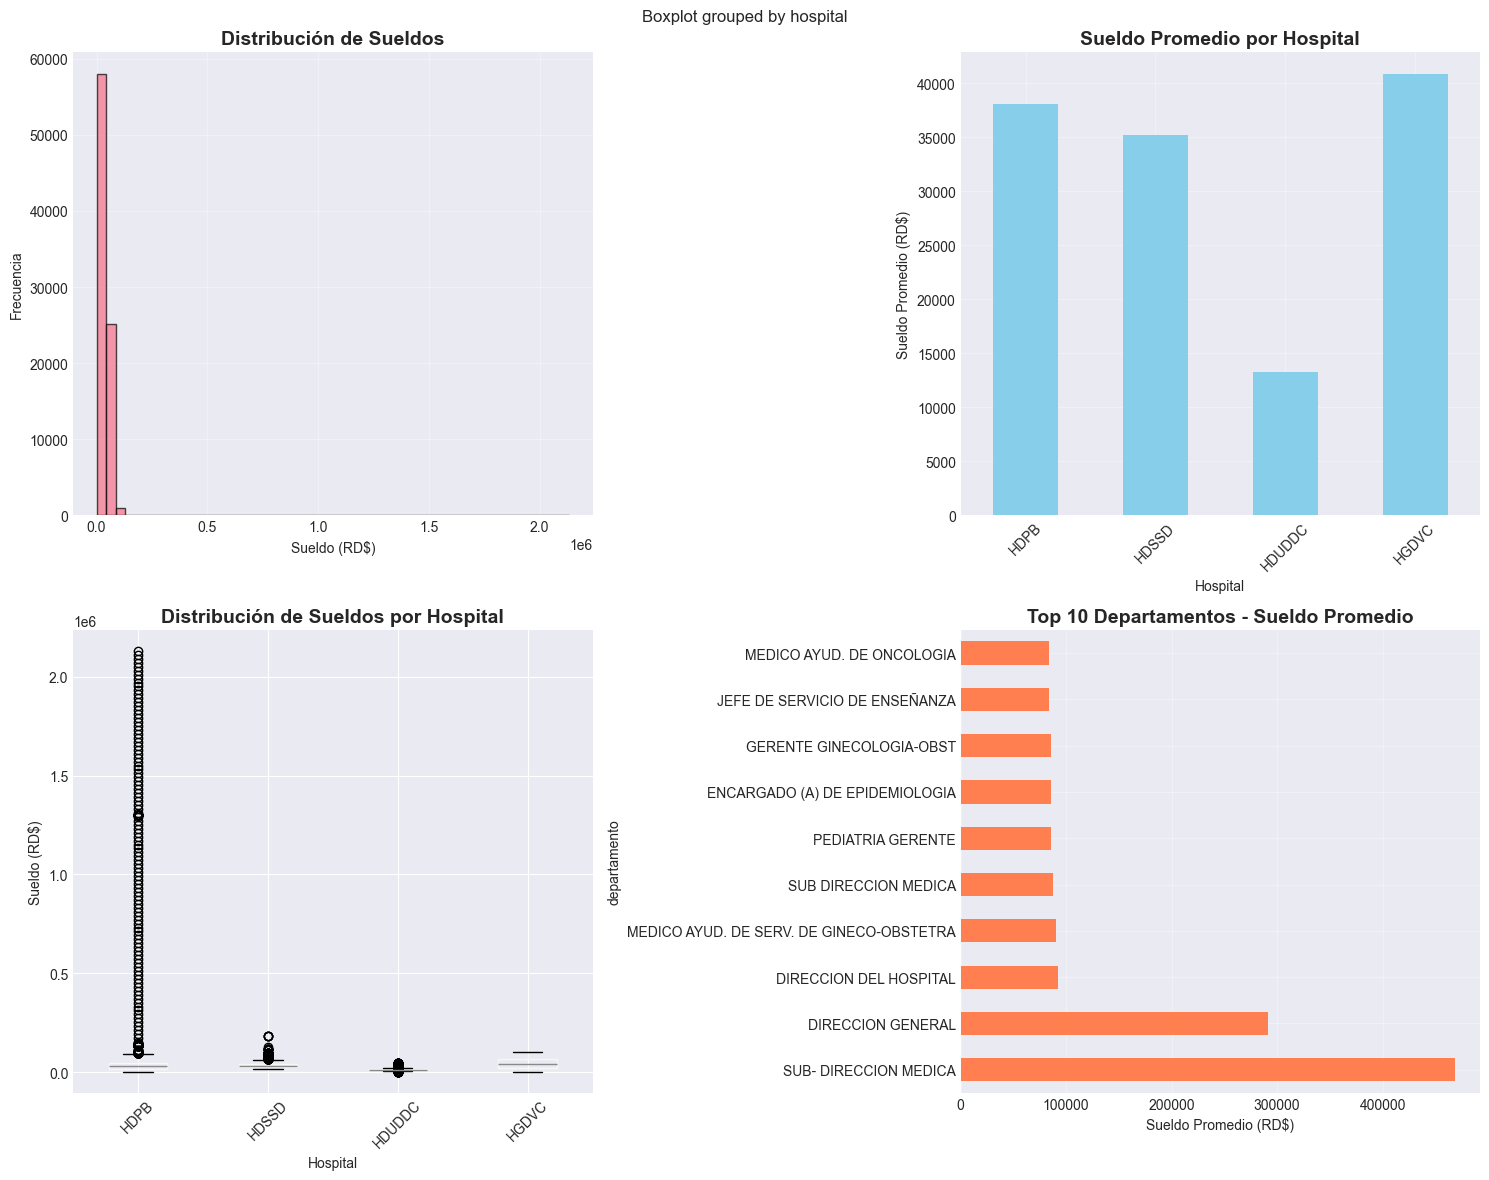

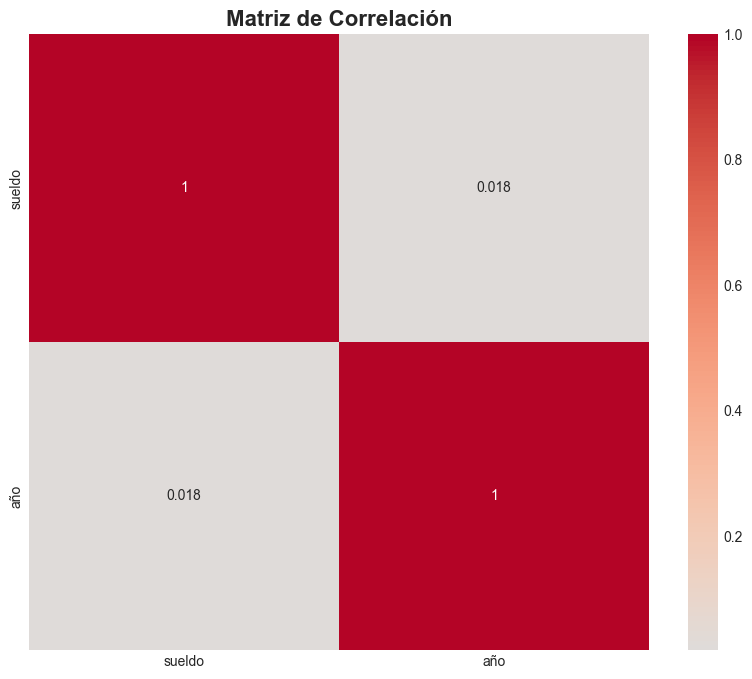

Análisis exploratorio completado


In [5]:
print("\n" + "="*60)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*60)

# Estadísticas descriptivas
print("\nEstadísticas Descriptivas del Sueldo:")
print(df_completo['sueldo'].describe())

print("\nDistribución por Hospital:")
print(df_completo['hospital'].value_counts())

print("\nTop 10 Cargos más comunes:")
print(df_completo['cargo'].value_counts().head(10))

print("\nDistribución por Estatus:")
print(df_completo['estatus'].value_counts())

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de Sueldos
axes[0, 0].hist(df_completo['sueldo'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Sueldos', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sueldo (RD$)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# 2. Sueldo por Hospital
df_completo.groupby('hospital')['sueldo'].mean().plot(kind='bar', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Sueldo Promedio por Hospital', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Hospital')
axes[0, 1].set_ylabel('Sueldo Promedio (RD$)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Boxplot de Sueldos por Hospital
df_completo.boxplot(column='sueldo', by='hospital', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Sueldos por Hospital', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hospital')
axes[1, 0].set_ylabel('Sueldo (RD$)')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Top 10 Departamentos por Sueldo Promedio
top_depts = df_completo.groupby('departamento')['sueldo'].mean().nlargest(10)
top_depts.plot(kind='barh', ax=axes[1, 1], color='coral')
axes[1, 1].set_title('Top 10 Departamentos - Sueldo Promedio', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sueldo Promedio (RD$)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Matriz de correlación (si hay columnas numéricas adicionales)
columnas_numericas = df_completo.select_dtypes(include=[np.number]).columns
if len(columnas_numericas) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_completo[columnas_numericas].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación', fontsize=16, fontweight='bold')
    plt.show()
print("Análisis exploratorio completado")

## 5. Preparación de Datos para Modelado

In [6]:
# Crear features adicionales
df_modelo = df_completo.copy()

# Feature Engineering
df_modelo['longitud_nombre'] = df_modelo['nombre_completo'].str.len()
df_modelo['palabras_cargo'] = df_modelo['cargo'].str.split().str.len()

# Rellenar valores nulos antes de codificar
df_modelo['hospital'] = df_modelo['hospital'].fillna('DESCONOCIDO')
df_modelo['departamento'] = df_modelo['departamento'].fillna('DESCONOCIDO')
df_modelo['cargo'] = df_modelo['cargo'].fillna('DESCONOCIDO')
df_modelo['estatus'] = df_modelo['estatus'].fillna('DESCONOCIDO')
df_modelo['año'] = df_modelo['año'].fillna(df_modelo['año'].mode()[0])

# Codificación de variables categóricas
le_hospital = LabelEncoder()
le_departamento = LabelEncoder()
le_cargo = LabelEncoder()
le_estatus = LabelEncoder()

df_modelo['hospital_encoded'] = le_hospital.fit_transform(df_modelo['hospital'])
df_modelo['departamento_encoded'] = le_departamento.fit_transform(df_modelo['departamento'])
df_modelo['cargo_encoded'] = le_cargo.fit_transform(df_modelo['cargo'])
df_modelo['estatus_encoded'] = le_estatus.fit_transform(df_modelo['estatus'])

# Si existe género, codificarlo
if 'genero' in df_modelo.columns:
    df_modelo['genero'] = df_modelo['genero'].fillna('DESCONOCIDO')
    le_genero = LabelEncoder()
    df_modelo['genero_encoded'] = le_genero.fit_transform(df_modelo['genero'])

# Seleccionar features para el modelo
feature_cols = ['hospital_encoded', 'departamento_encoded', 'cargo_encoded', 
                'estatus_encoded', 'año', 'longitud_nombre', 'palabras_cargo']

if 'genero_encoded' in df_modelo.columns:
    feature_cols.append('genero_encoded')

X = df_modelo[feature_cols]
y = df_modelo['sueldo']

# Eliminar filas con NaN en features o target
mask_valid = X.notna().all(axis=1) & y.notna()
X = X[mask_valid]
y = y[mask_valid]

print(f"\nFilas válidas después de eliminar NaN: {len(X)}")

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDatos preparados para modelado")
print(f"Features utilizadas: {feature_cols}")
print(f"Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto prueba: {X_test.shape}")


Filas válidas después de eliminar NaN: 83924

Datos preparados para modelado
Features utilizadas: ['hospital_encoded', 'departamento_encoded', 'cargo_encoded', 'estatus_encoded', 'año', 'longitud_nombre', 'palabras_cargo', 'genero_encoded']
Tamaño conjunto entrenamiento: (67139, 8)
Tamaño conjunto prueba: (16785, 8)


## 6. Entrenamiento de los 10 Modelos de Regresión

In [7]:
print("\n" + "="*60)
print("ENTRENAMIENTO DE MODELOS")
print("="*60)

# Diccionario de modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    # 'SVR': SVR(kernel='rbf', C=1.0),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Almacenar resultados
resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando {nombre}...")
    
    # Entrenar modelo
    modelo.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train_scaled)
    y_pred_test = modelo.predict(X_test_scaled)
    
    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Guardar resultados
    resultados.append({
        'Modelo': nombre,
        'MSE_Train': mse_train,
        'MSE_Test': mse_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'R2_Train': r2_train,
        'R2_Test': r2_test
    })
    
    print(f"  R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:,.2f}")

print("\nTodos los modelos entrenados exitosamente")


ENTRENAMIENTO DE MODELOS

Entrenando Linear Regression...
  R² Test: 0.0290 | RMSE Test: 54,250.49

Entrenando Ridge...
  R² Test: 0.0290 | RMSE Test: 54,250.49

Entrenando Lasso...
  R² Test: 0.0290 | RMSE Test: 54,250.49

Entrenando ElasticNet...
  R² Test: 0.0249 | RMSE Test: 54,365.64

Entrenando Decision Tree...
  R² Test: 0.5808 | RMSE Test: 35,645.87

Entrenando Random Forest...
  R² Test: 0.5837 | RMSE Test: 35,524.69

Entrenando Gradient Boosting...
  R² Test: 0.5791 | RMSE Test: 35,720.54

Entrenando AdaBoost...
  R² Test: 0.2210 | RMSE Test: 48,591.35

Entrenando K-Nearest Neighbors...


KeyboardInterrupt: 

## 7. Evaluación y Comparación de Modelos


RESULTADOS DE EVALUACIÓN

Tabla de Métricas Completa:
           Modelo    MSE_Train     MSE_Test   RMSE_Train    RMSE_Test    MAE_Train     MAE_Test  R2_Train  R2_Test
Linear Regression 2.599659e+09 2.943116e+09 50986.848139 54250.493438 18958.726417 19120.757058  0.032509 0.029041
            Ridge 2.599659e+09 2.943116e+09 50986.848139 54250.494167 18958.729391 19120.760979  0.032509 0.029041
            Lasso 2.599659e+09 2.943116e+09 50986.848301 54250.493980 18958.808752 19120.849233  0.032509 0.029041
       ElasticNet 2.611074e+09 2.955622e+09 51098.666573 54365.635845 19183.052088 19357.569770  0.028261 0.024915
    Decision Tree 1.264913e+09 1.270628e+09 35565.614219 35645.871352  6620.125659  6749.400925  0.529249 0.580809
    Random Forest 1.254619e+09 1.262004e+09 35420.608134 35524.689122  6467.387276  6570.766936  0.533080 0.583654
Gradient Boosting 1.281569e+09 1.275957e+09 35799.012384 35720.542362  6808.294228  6776.125599  0.523050 0.579051
         AdaBoost 2.48385

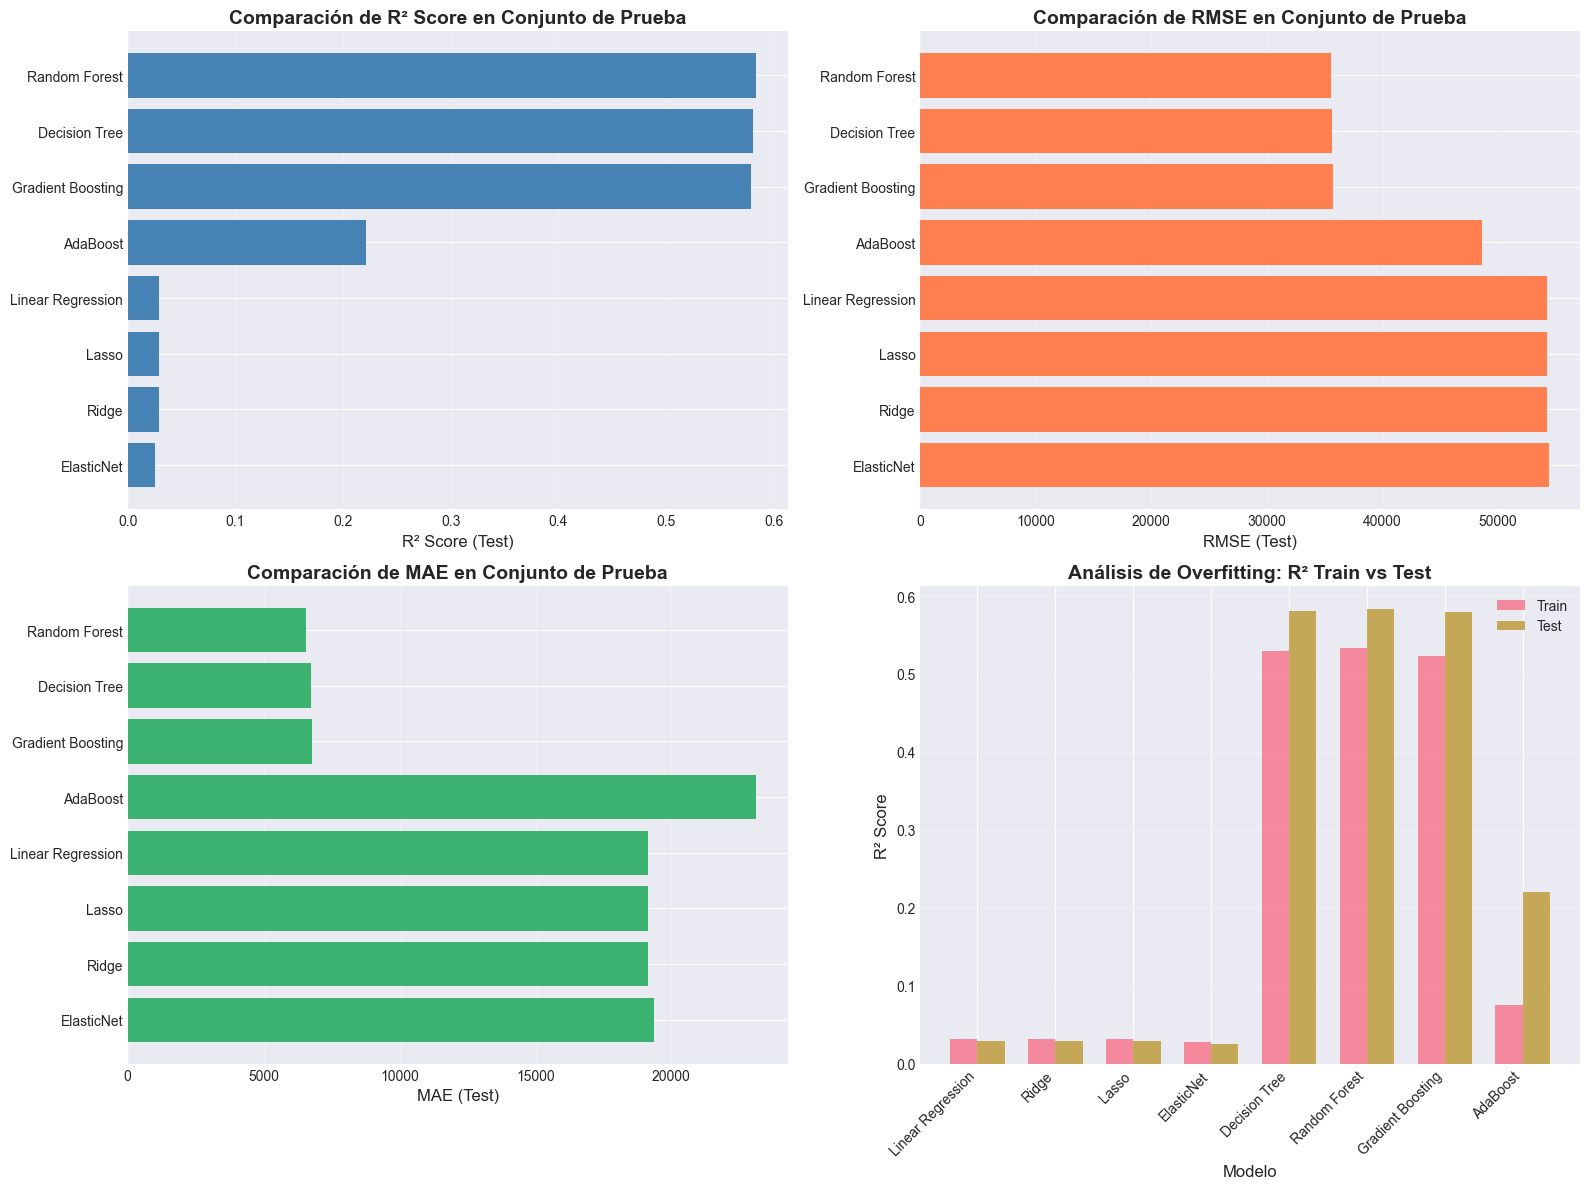


Resultados de evaluación mostrados exitosamente


In [8]:
df_resultados = pd.DataFrame(resultados)

print("\n" + "="*60)
print("RESULTADOS DE EVALUACIÓN")
print("="*60)
print("\nTabla de Métricas Completa:")
print(df_resultados.to_string(index=False))

# Mejor modelo según R²
mejor_modelo_idx = df_resultados['R2_Test'].idxmax()
mejor_modelo_nombre = df_resultados.loc[mejor_modelo_idx, 'Modelo']
mejor_r2 = df_resultados.loc[mejor_modelo_idx, 'R2_Test']

print(f"\nMEJOR MODELO: {mejor_modelo_nombre}")
print(f"   R² en Test: {mejor_r2:.4f}")

# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de R² Score
df_resultados_sorted = df_resultados.sort_values('R2_Test', ascending=True)
axes[0, 0].barh(df_resultados_sorted['Modelo'], df_resultados_sorted['R2_Test'], color='steelblue')
axes[0, 0].set_xlabel('R² Score (Test)', fontsize=12)
axes[0, 0].set_title('Comparación de R² Score en Conjunto de Prueba', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Comparación de RMSE
axes[0, 1].barh(df_resultados_sorted['Modelo'], df_resultados_sorted['RMSE_Test'], color='coral')
axes[0, 1].set_xlabel('RMSE (Test)', fontsize=12)
axes[0, 1].set_title('Comparación de RMSE en Conjunto de Prueba', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Comparación de MAE
axes[1, 0].barh(df_resultados_sorted['Modelo'], df_resultados_sorted['MAE_Test'], color='mediumseagreen')
axes[1, 0].set_xlabel('MAE (Test)', fontsize=12)
axes[1, 0].set_title('Comparación de MAE en Conjunto de Prueba', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Overfitting Analysis (R² Train vs Test)
x_pos = np.arange(len(df_resultados))
width = 0.35
axes[1, 1].bar(x_pos - width/2, df_resultados['R2_Train'], width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, df_resultados['R2_Test'], width, label='Test', alpha=0.8)
axes[1, 1].set_xlabel('Modelo', fontsize=12)
axes[1, 1].set_ylabel('R² Score', fontsize=12)
axes[1, 1].set_title('Análisis de Overfitting: R² Train vs Test', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
print("\nResultados de evaluación mostrados exitosamente")

## 8. Función de Predicción para Nuevos Datos

In [10]:
def predecir_desde_csv(archivo_csv, hospital_code, modelo_elegido='Random Forest'):
    print(f"\n{'='*60}")
    print(f"PREDICCIÓN DE SUELDOS")
    print(f"{'='*60}")
    print(f"Archivo: {archivo_csv}")
    print(f"Hospital: {hospital_code}")
    print(f"Modelo: {modelo_elegido}\n")
    
    # Cargar y estandarizar datos
    df_nuevo = cargar_csv_hospital(archivo_csv, hospital_code)
    df_nuevo['sueldo'] = df_nuevo['sueldo'].apply(limpiar_sueldo)
    
    # Normalizar texto
    for col in ['nombre_completo', 'departamento', 'cargo', 'estatus', 'mes']:
        if col in df_nuevo.columns:
            df_nuevo[col] = df_nuevo[col].str.upper().str.strip()
    
    # Rellenar valores nulos
    df_nuevo['hospital'] = df_nuevo['hospital'].fillna('DESCONOCIDO')
    df_nuevo['departamento'] = df_nuevo['departamento'].fillna('DESCONOCIDO')
    df_nuevo['cargo'] = df_nuevo['cargo'].fillna('DESCONOCIDO')
    df_nuevo['estatus'] = df_nuevo['estatus'].fillna('DESCONOCIDO')
    df_nuevo['año'] = pd.to_numeric(df_nuevo['año'], errors='coerce')
    df_nuevo['año'] = df_nuevo['año'].fillna(df_nuevo['año'].mode()[0] if len(df_nuevo['año'].mode()) > 0 else 2024)
    
    # Feature Engineering
    df_nuevo['longitud_nombre'] = df_nuevo['nombre_completo'].str.len()
    df_nuevo['palabras_cargo'] = df_nuevo['cargo'].str.split().str.len()
    
    # Codificación
    # Manejar categorías no vistas
    try:
        df_nuevo['hospital_encoded'] = le_hospital.transform(df_nuevo['hospital'])
    except:
        df_nuevo['hospital_encoded'] = 0  # Valor por defecto para categorías no vistas
    
    # Para departamento, cargo y estatus, manejar valores no vistos
    def safe_transform(encoder, values, default=0):
        result = []
        for val in values:
            try:
                result.append(encoder.transform([val])[0])
            except:
                result.append(default)
        return result
    
    df_nuevo['departamento_encoded'] = safe_transform(le_departamento, df_nuevo['departamento'])
    df_nuevo['cargo_encoded'] = safe_transform(le_cargo, df_nuevo['cargo'])
    df_nuevo['estatus_encoded'] = safe_transform(le_estatus, df_nuevo['estatus'])
    
    if 'genero' in df_nuevo.columns:
        df_nuevo['genero'] = df_nuevo['genero'].fillna('DESCONOCIDO')
        df_nuevo['genero_encoded'] = safe_transform(le_genero, df_nuevo['genero'])
    
    # Preparar features
    X_nuevo = df_nuevo[feature_cols]
    
    # Rellenar cualquier NaN restante con 0
    X_nuevo = X_nuevo.fillna(0)
    
    X_nuevo_scaled = scaler.transform(X_nuevo)
    
    # Realizar predicción con el modelo elegido
    modelo_seleccionado = modelos[modelo_elegido]
    predicciones = modelo_seleccionado.predict(X_nuevo_scaled)
    
    # Agregar predicciones al DataFrame
    df_nuevo['sueldo_predicho'] = predicciones
    
    # Solo calcular diferencias si hay sueldos reales
    if df_nuevo['sueldo'].notna().any():
        df_nuevo['diferencia'] = df_nuevo['sueldo'] - df_nuevo['sueldo_predicho']
        df_nuevo['error_porcentual'] = (abs(df_nuevo['diferencia']) / df_nuevo['sueldo'] * 100).round(2)
        
        # Mostrar resultados
        print(f"Predicciones realizadas para {len(df_nuevo)} registros\n")
        print("Resumen de Predicciones:")
        print(f"   Sueldo Real Promedio: RD$ {df_nuevo['sueldo'].mean():,.2f}")
        print(f"   Sueldo Predicho Promedio: RD$ {df_nuevo['sueldo_predicho'].mean():,.2f}")
        print(f"   MAE: RD$ {abs(df_nuevo['diferencia']).mean():,.2f}")
        print(f"   Error Porcentual Promedio: {df_nuevo['error_porcentual'].mean():.2f}%")
        
        return df_nuevo[['nombre_completo', 'cargo', 'departamento', 'sueldo', 
                         'sueldo_predicho', 'diferencia', 'error_porcentual']]
    else:
        print(f"Predicciones realizadas para {len(df_nuevo)} registros\n")
        print("Resumen de Predicciones:")
        print(f"   Sueldo Predicho Promedio: RD$ {df_nuevo['sueldo_predicho'].mean():,.2f}")
        
        return df_nuevo[['nombre_completo', 'cargo', 'departamento', 'sueldo_predicho']]

# Ejemplo de uso de la función de predicción
print("\n" + "="*60)
print("PROYECTO COMPLETADO EXITOSAMENTE")
print("="*60)
print("\nResumen del Pipeline:")
print("Carga y concatenación de datos de 4 hospitales")
print("Limpieza y preprocesamiento completo")
print("Análisis exploratorio con visualizaciones")
print("10 modelos de regresión entrenados y evaluados")
print(f"Mejor modelo: {mejor_modelo_nombre} (R² = {mejor_r2:.4f})")
print("Función de predicción lista para usar")
print("\nYa funciona?")


PROYECTO COMPLETADO EXITOSAMENTE

Resumen del Pipeline:
Carga y concatenación de datos de 4 hospitales
Limpieza y preprocesamiento completo
Análisis exploratorio con visualizaciones
10 modelos de regresión entrenados y evaluados
Mejor modelo: Random Forest (R² = 0.5837)
Función de predicción lista para usar

Ya funciona?


## Función de Predicción

In [ ]:
df_predicciones = predecir_desde_csv(
    archivo_csv='./data/csv/.csv',
    hospital_code='',
    modelo_elegido='Random Forest'
)

# Ver primeras predicciones
print(df_predicciones.head(10))